In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [3]:
#convert MNIST image files into tensor of 4 dim (#images,height,width,channel)
transform = transforms.ToTensor()
training_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
testing_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)
training_data, testing_data 

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [4]:
# Data Loader
train_loader = DataLoader(training_data, batch_size=8, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=8, shuffle=False)

In [54]:
class ConvNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(5*5*16, 3*16)
        self.fc2 = nn.Linear(3*16, 2*16)
        self.fc3 = nn.Linear(2*16, 10)
        
    def forward(self, X):
        # conv1
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        # conv2
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        # flatten
        X = X.view(-1, 5*5*16)
        # fully connected layers
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

torch.manual_seed(69)
model = ConvNetwork()
model.eval()

In [56]:
# loss function optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [57]:
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

#epoch loops
for i in range(epochs):
    train_ok_count = 0
    test_ok_count = 0
    
    #Train
    for j, (X_train, Y_train) in enumerate(train_loader):
        j+=1
        Y_predicted = model(X_train)
        loss = criterion(Y_predicted, Y_train)
        predicted = torch.max(Y_predicted.data, 1)[1]
        batch_correct = (predicted == Y_train).sum()
        train_ok_count += batch_correct
        
        #update params
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #print out result
        if j%600 == 0:
            print(f'Epoch: {i+1} \t Batch: {j} \t Loss: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(train_ok_count)
    
    #test
    with torch.no_grad():
        for j, (X_test, Y_test) in enumerate(train_loader):
            Y_predicted = model(X_test)
            predicted = torch.max(Y_predicted.data, 1)[1]
            test_ok_count += (predicted == Y_test).sum()
    
    loss = criterion(Y_predicted, Y_test)
    test_losses.append(loss)
    test_correct.append(test_ok_count)
    
current_time = time.time()

total_time = current_time - start_time
print(f'training took: {total_time/60} minutes')

Epoch: 1 	 Batch: 600 	 Loss: 0.29030537605285645
Epoch: 1 	 Batch: 1200 	 Loss: 0.0696461945772171
Epoch: 1 	 Batch: 1800 	 Loss: 0.28086426854133606
Epoch: 1 	 Batch: 2400 	 Loss: 0.10585780441761017
Epoch: 1 	 Batch: 3000 	 Loss: 0.015881527215242386
Epoch: 1 	 Batch: 3600 	 Loss: 0.24224035441875458
Epoch: 1 	 Batch: 4200 	 Loss: 0.0014351587742567062
Epoch: 1 	 Batch: 4800 	 Loss: 0.0026066177524626255
Epoch: 1 	 Batch: 5400 	 Loss: 0.21729879081249237
Epoch: 1 	 Batch: 6000 	 Loss: 0.06697786599397659
Epoch: 2 	 Batch: 600 	 Loss: 0.023704875260591507
Epoch: 2 	 Batch: 1200 	 Loss: 0.3251686096191406
Epoch: 2 	 Batch: 1800 	 Loss: 0.08959764242172241
Epoch: 2 	 Batch: 2400 	 Loss: 0.05109560489654541
Epoch: 2 	 Batch: 3000 	 Loss: 0.5199720859527588
Epoch: 2 	 Batch: 3600 	 Loss: 0.008995835669338703
Epoch: 2 	 Batch: 4200 	 Loss: 0.008661376312375069
Epoch: 2 	 Batch: 4800 	 Loss: 0.15844812989234924
Epoch: 2 	 Batch: 5400 	 Loss: 0.042103659361600876
Epoch: 2 	 Batch: 6000 	 Lo

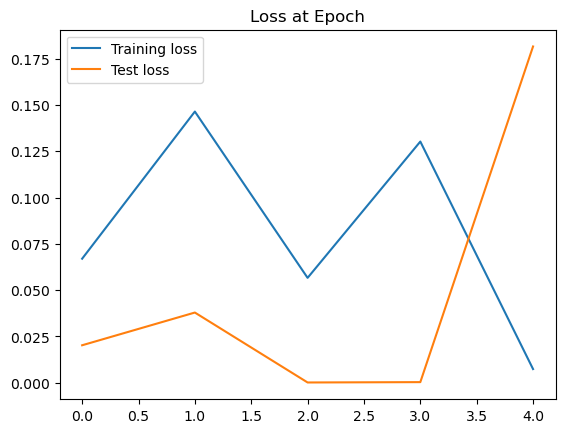

In [58]:
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.title('Loss at Epoch')
plt.legend()

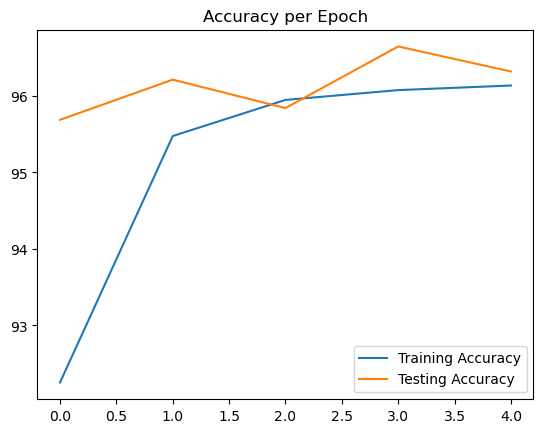

In [59]:
#Accuracy graph
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/600 for t in test_correct], label='Testing Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

In [60]:
test_load_everything = DataLoader(testing_data, batch_size=10000, shuffle=False)
with torch.no_grad():
    correct =0
    for X_test, Y_test in test_load_everything:
        Y_predicted = model(X_test)
        predicted = torch.max(Y_predicted, 1)[1]
        correct += (predicted == Y_test).sum()

print(f'Correct prdictions: {correct.item()/len(X_test) * 100}%')

Correct prdictions: 95.95%
